In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import torch
from torch.distributions import MixtureSameFamily, MultivariateNormal, Categorical
from IPython import display

from distillation.networks.mlp import MLPUNetTimesCond, MLPUNet, MLPUNetTimeCond
from distillation.algorithms.mean_flows import MeanFlow
from distillation.algorithms.sid import ScoreIdentityDistillation
from distillation.data.bidimensional import MixGauss

In [3]:
class MixGauss2:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        means = torch.tensor([[4.0, 0.0], [5.0, 1.0], [4.5, 2.0]])
        covs = torch.stack([torch.eye(2), torch.eye(2), torch.eye(2)], dim=0) / 50
        self.distribution = MixtureSameFamily(
            mixture_distribution=Categorical(probs=torch.tensor([0.333, 0.333, 0.333])),
            component_distribution=MultivariateNormal(means, covs)
        )
    def sample(self):
        return self.distribution.sample(sample_shape=(self.batch_size, ))
    def get_dataloader(self):
        while True:
            yield self.sample()

### Mean Flows

In [7]:
dset = MixGauss2(1024)
dl = dset.get_dataloader()
device = "cuda:0"

In [9]:
mlp = MLPUNetTimesCond(data_dim=2, n_layers=3, n_channels=512, act=torch.nn.SELU(), norm=None)
mf = MeanFlow(model=mlp, lr=1e-3, ema_beta=0.99)

In [12]:
mf.lr = 1e-4

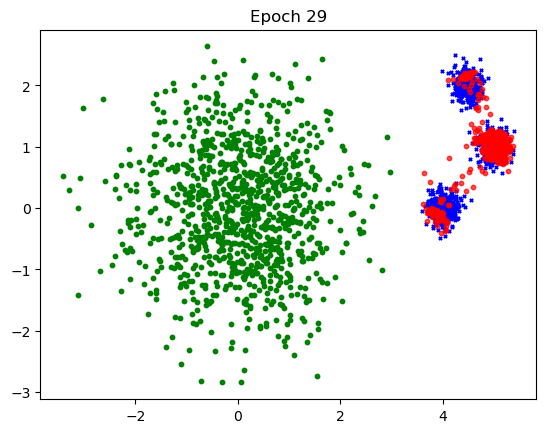

In [13]:
fig, ax = plt.subplots()
hdisplay = display.display(fig, display_id=True)
target_dist = next(dl)
sampling_rng = torch.Generator(device=device)

for i in range(30):
    mf.pretrain(dl, n_steps=500, device=device)
    samples = mf.sample(n_steps=1, sample_size=(1024, 2), device=device, rng=sampling_rng)
    ax.clear()
    ax.scatter(target_dist[:, 0], target_dist[:, 1], c='b', marker='x', s=5)
    ax.scatter(samples[0][:, 0], samples[0][:, 1], c='g', s=10)
    ax.scatter(samples[-1][:, 0], samples[-1][:, 1], c='r', s=10, alpha=0.7)
    ax.set_title(f"Epoch {i}")
    hdisplay.update(fig)
plt.close(fig)

## SiD

In [70]:
dset = MixGauss2(1024)
dl = dset.get_dataloader()
device = "cuda:0"

In [71]:
pretr_mlp = MLPUNetTimeCond(data_dim=2, n_layers=3, n_channels=512, act=torch.nn.SiLU(), norm=None)
aux_mlp = MLPUNetTimeCond(data_dim=2, n_layers=3, n_channels=512, act=torch.nn.SiLU(), norm=None)
dist_mlp = MLPUNet(data_dim=2, n_layers=3, n_channels=512, act=torch.nn.SiLU(), norm=None)
sid = ScoreIdentityDistillation(
    pretr_model=pretr_mlp, 
    aux_model=aux_mlp,
    dist_model=dist_mlp,
    pretraining_lr=1e-3,
    auxiliary_lr=1e-5,
    distillation_lr=1e-5,
    alpha=0.75,
    only_loss_one=True
)

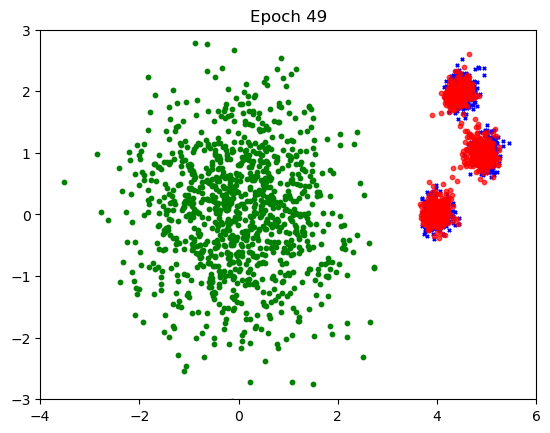

In [72]:
fig, ax = plt.subplots()
hdisplay: display.DisplayHandle = display.display(fig, display_id=True) # type: ignore
target_dist = next(dl)
sampling_rng = torch.Generator(device=device)

for i in range(50):
    sid.pretrain(dl, n_steps=100, device=device)
    samples = sid.sample_pretrained(n_steps=100, sample_size=(1024, 2), device=device, rng=sampling_rng)
    ax.clear()
    ax.scatter(target_dist[:, 0], target_dist[:, 1], c='b', marker='x', s=5)
    ax.scatter(samples[0][:, 0], samples[0][:, 1], c='g', s=10)
    ax.scatter(samples[-1][:, 0], samples[-1][:, 1], c='r', s=10, alpha=0.7)
    ax.set_title(f"Epoch {i}")
    ax.set_xlim([-4, 6])
    ax.set_ylim([-3, 3])
    hdisplay.update(fig)
plt.close(fig)

In [73]:
sid.distillation_lr = 1e-5
sid.auxiliary_lr = 1e-5
sid.alpha = 0.5
sid.reset_distillation()

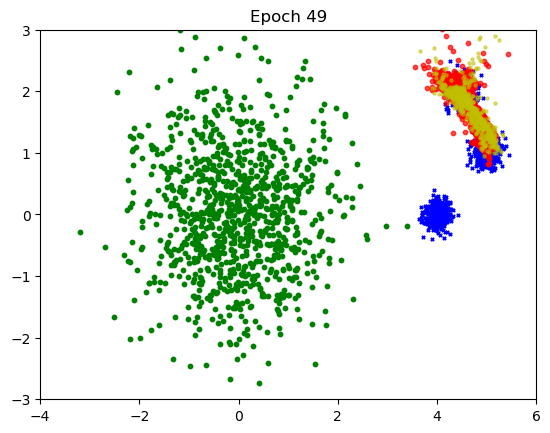

In [74]:
fig, ax = plt.subplots()
hdisplay: display.DisplayHandle = display.display(fig, display_id=True) # type: ignore
target_dist = next(dl)
sampling_rng = torch.Generator(device=device)

for i in range(50):
    sid.distill(dl, n_steps=200, device=device)

    samples_dist = sid.sample_distilled(sample_size=(1024, 2), device=device, rng=sampling_rng)
    samples_aux = sid.sample_pretrained(n_steps=20, sample_size=(1024, 2), device=device, rng=sampling_rng, model=sid.aux_model)
    ax.clear()
    ax.scatter(target_dist[:, 0], target_dist[:, 1], c='b', marker='x', s=5)
    ax.scatter(samples_dist[0][:, 0], samples_dist[0][:, 1], c='g', s=10)
    ax.scatter(samples_dist[-1][:, 0], samples_dist[-1][:, 1], c='r', s=10, alpha=0.7)
    ax.scatter(samples_aux[-1][:, 0], samples_aux[-1][:, 1], c="y", s=5, alpha=0.5)
    ax.set_title(f"Epoch {i}")
    ax.set_xlim([-4, 6])
    ax.set_ylim([-3, 3])
    hdisplay.update(fig)

plt.close(fig)

### Diffinstruct

In [55]:
dset = MixGauss(512)
dl = dset.get_dataloader()
device = "cuda:0"

In [66]:
from distillation.algorithms.diffinstruct import DiffInstruct

pretr_mlp = MLPUNetTimeCond(data_dim=2, n_layers=3, n_channels=512, act=torch.nn.ReLU(), norm=None)
aux_mlp = MLPUNetTimeCond(data_dim=2, n_layers=3, n_channels=512, act=torch.nn.ReLU(), norm=None)
dist_mlp = MLPUNet(data_dim=2, n_layers=3, n_channels=512, act=torch.nn.ReLU(), norm=None)
di = DiffInstruct(
    pretr_model=pretr_mlp,
    aux_model=aux_mlp,
    dist_model=dist_mlp,
    pretraining_lr=1e-3,
    auxiliary_lr=1e-5,
    distillation_lr=1e-5,
    seed=43,
)

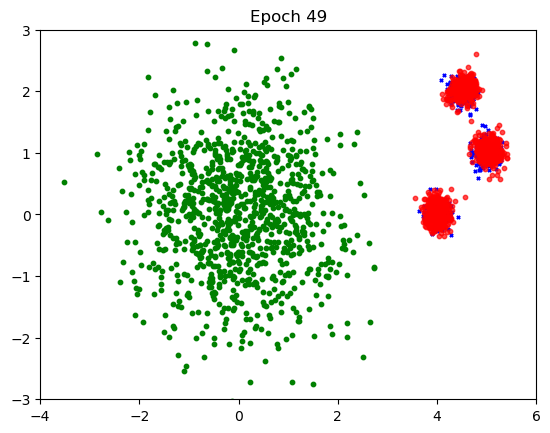

In [67]:
fig, ax = plt.subplots()
hdisplay: display.DisplayHandle = display.display(fig, display_id=True) # type: ignore
target_dist = next(dl)
sampling_rng = torch.Generator(device=device)

for i in range(50):
    di.pretrain(dl, n_steps=200, device=device)
    samples = di.sample_pretrained(n_steps=100, sample_size=(1024, 2), device=device, rng=sampling_rng)
    ax.clear()
    ax.scatter(target_dist[:, 0], target_dist[:, 1], c='b', marker='x', s=5)
    ax.scatter(samples[0][:, 0], samples[0][:, 1], c='g', s=10)
    ax.scatter(samples[-1][:, 0], samples[-1][:, 1], c='r', s=10, alpha=0.7)
    ax.set_title(f"Epoch {i}")
    ax.set_xlim([-4, 6])
    ax.set_ylim([-3, 3])
    hdisplay.update(fig)
plt.close(fig)

In [68]:
di.distillation_lr = 1e-5
di.auxiliary_lr = 1e-5
di.reset_distillation()

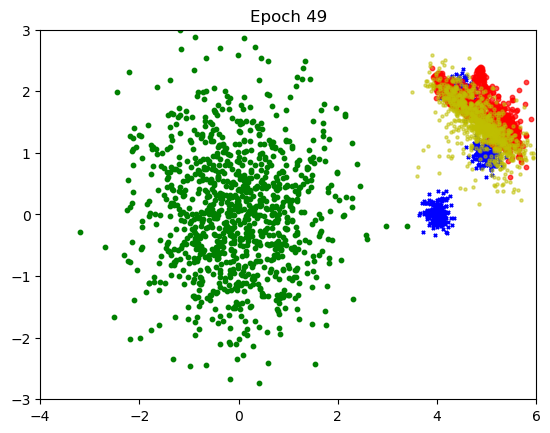

In [69]:
fig, ax = plt.subplots()
hdisplay: display.DisplayHandle = display.display(fig, display_id=True) # type: ignore
target_dist = next(dl)
sampling_rng = torch.Generator(device=device)

for i in range(50):
    di.distill(dl, n_steps=100, device=device)

    samples_dist = di.sample_distilled(sample_size=(1024, 2), device=device, rng=sampling_rng)
    samples_aux = di.sample_pretrained(n_steps=20, sample_size=(1024, 2), device=device, rng=sampling_rng, model=di.aux_model)
    ax.clear()
    ax.scatter(target_dist[:, 0], target_dist[:, 1], c='b', marker='x', s=5)
    ax.scatter(samples_dist[0][:, 0], samples_dist[0][:, 1], c='g', s=10)
    ax.scatter(samples_dist[-1][:, 0], samples_dist[-1][:, 1], c='r', s=10, alpha=0.7)
    ax.scatter(samples_aux[-1][:, 0], samples_aux[-1][:, 1], c="y", s=5, alpha=0.5)
    ax.set_title(f"Epoch {i}")
    ax.set_xlim([-4, 6])
    ax.set_ylim([-3, 3])
    hdisplay.update(fig)

plt.close(fig)

In [ ]:
print(